# Performance of benchmark model (SVM) on prioritizing causal SNPs

In [5]:
import numpy as np
import pandas as pd
import pysam

from sklearn import svm
from sklearn import metrics 
from sklearn.svm import LinearSVR
from scipy import sparse
from sklearn.externals import joblib


In [6]:
model = joblib.load('finalized_model.sav')

In [7]:
# load list of top SNPs
snp_dir_name = "/data/list_of_snps/"

# uncomment if using top 200
# data = pd.read_csv(snp_dir_name+"TOP_200_SNPS.txt",delim_whitespace=True)
# saved_dir_name = dir_name = '/data/top200snps/'

# uncomment if using top 1000
data = pd.read_csv(snp_dir_name+"TOP_10000_SNPS.txt",delim_whitespace=True)
saved_dir_name = '/data/top10000snps/'

# data.info()

In [8]:
'''
Function to extract X data for benchmark regressor
(Those regressors predict one point at a time.)
'''
def extract_benchmark_X(sample_Xs, half_center_size, half_feature_size):
       
    # feature (X)
    ft_center_idx = int(np.ceil(sample_Xs.shape[0]/2))
    ftlb_h_idx = ft_center_idx-half_center_size
    ftlb_t_idx = ft_center_idx+half_center_size

    seg_X = np.empty([1,2*half_feature_size*sample_Xs.shape[1]])
    for idx in range(ftlb_h_idx,ftlb_t_idx):
        ft_h_idx = idx-half_feature_size
        ft_t_idx = idx+half_feature_size
        seg_features_idx = sample_Xs[ft_h_idx:ft_t_idx,:]
        seg_features_idx = seg_features_idx.reshape(1,-1)
        seg_X = np.concatenate((seg_X, seg_features_idx), axis=0)  
    seg_X = seg_X[1:,:]  

    # X for SVM 
    bm_X = seg_X.reshape(-1,seg_X.shape[-1])
    
    return bm_X

In [13]:
def extract_benchmark_y(sample_ys, half_center_size):
       
    # label (Y)
    lb_center_idx = int(np.ceil(sample_ys.shape[0]/2))
    lb_h_idx = lb_center_idx-half_center_size
    lb_t_idx = lb_center_idx+half_center_size
    seg_y = sample_ys[lb_h_idx:lb_t_idx]

    # y for SVM 
    bm_y = seg_y.flatten()
    
    return bm_y

In [14]:
half_center_size = 2  # +/- values around a peak to predict
half_feature_size = 25 # +/- values around each point to take in as features

In [15]:
err_SNPs_idx = [3082, 8246, 8449, 9509]
# valid_ind = list(range(0,len(index_list)))
# for err in err_SNPs_idx:
#     valid_ind.remove(err)
# print(len(valid_ind))

In [ ]:
# Load encoding directly from saved files

index_list = data.index.values.tolist()
sum_diff = list()
max_diff = list()
max_log_fold = list()
mse = list()

for i in range(0,len(index_list)):
    if i in err_SNPs_idx:
        sum_diff.append(0)
        max_diff.append(0)
        max_log_fold.append(0)
    else:    
        snp = data.loc[index_list[i],:]
        ref_encoding = np.load(saved_dir_name +"snp"+str(i)+"_ref.npy", allow_pickle=True) 
        alt_encoding = np.load(saved_dir_name +"snp"+str(i)+"_alt.npy", allow_pickle=True)
        atac = np.load(saved_dir_name +"snp"+str(i)+"_atac.npy", allow_pickle=True)

        # Apply model to the sequences: ref_encoding and alt_encoding
        # encoding's shape: (13000,4)
        ref_X = extract_benchmark_X(ref_encoding, half_center_size,half_feature_size)
        alt_X = extract_benchmark_X(alt_encoding, half_center_size,half_feature_size)
        s_ref_X = sparse.csr_matrix(ref_X)
        s_alt_X = sparse.csr_matrix(alt_X)
        true_y = extract_benchmark_y(atac, half_center_size)

        ref_pred = model.predict(s_ref_X)
        alt_pred = model.predict(s_alt_X)
        # MSE
        svm_mse = metrics.mean_squared_error(true_y, ref_pred)  
        mse.append(svm_mse)

        diff = np.abs(alt_pred-ref_pred)
        sum_diff.append(np.sum(diff))
        max_diff.append(np.max(diff))
        max_log_fold.append(np.max(diff/ref_pred))
        
#         print(i,svm_mse)


In [11]:
data['sum_diff'] = sum_diff 
data['max_diff'] = max_diff 
data['max_log_fold'] = max_log_fold 

data.to_csv("/data/results/svm_10000.csv", index=True)

In [ ]:
import matplotlib.pyplot as plt

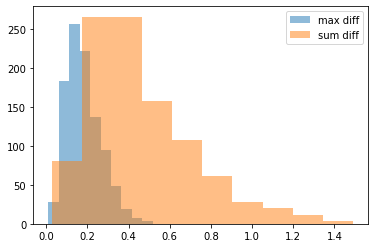

In [78]:
plt.figure()
plt.hist(max_diff, alpha=0.5, label="max diff")
plt.hist(sum_diff, alpha=0.5, label="sum diff")
plt.legend()

In [7]:
snps = np.array(data["SNP"].values.tolist())

In [20]:
max_diff_idx = np.argsort(-max_diff)
sum_diff_idx = np.argsort(-sum_diff)
max_lfc_idx = np.argsort(-max_log_fold)

max_diff = np.array(max_diff)
sum_diff = np.array(sum_diff)
max_log_fold = np.array(max_log_fold)

In [21]:
print("SVM Baseline")
print("Top 25 SNPs ranked by max diff")
print(np.transpose([snps[max_diff_idx[0:25]],max_diff[max_diff_idx[0:25]]]))
print("Top 25 SNPs ranked by max log fold")
print(np.transpose([snps[max_lfc_idx[0:25]],max_log_fold[max_lfc_idx[0:25]]]))

SVM Baseline
Top 25 SNPs ranked by max diff
[['rs1556515' '0.5739259796542244']
 ['rs216190' '0.4698349252738081']
 ['rs12714182' '0.46145527255105523']
 ['rs12938295' '0.4599538261636047']
 ['rs6502629' '0.4575484869145712']
 ['rs944766' '0.4497078939189554']
 ['rs7181432' '0.4478060112481146']
 ['rs2277545' '0.4458450201708051']
 ['rs6782181' '0.43848963750205816']
 ['rs2078851' '0.4358722709526486']
 ['rs10774625' '0.4282980991607026']
 ['rs10790162' '0.42668235961647283']
 ['rs2504927' '0.42316533453164573']
 ['rs6919980' '0.41742617126990567']
 ['rs12980480' '0.40804197786217866']
 ['rs10847503' '0.40630421064646804']
 ['rs9978407' '0.4009364966250588']
 ['rs9375990' '0.4007232525260278']
 ['rs3184504' '0.40010603097426234']
 ['rs4925093' '0.3987026934912401']
 ['rs10757264' '0.39860636696706764']
 ['rs950966' '0.39575370592719805']
 ['rs1056854' '0.3946499788753459']
 ['rs1004467' '0.39458992223795963']
 ['rs10774613' '0.3936514269037521']]
Top 25 SNPs ranked by max log fold
[['r